LIBRARY

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
import os

LOAD IMG

In [2]:
image_folder = "images"
images = []

for file in os.listdir(image_folder):
    img = cv2.imread(os.path.join(image_folder, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

print(f"Total gambar: {len(images)}")

Total gambar: 5


TAMMBAH NOISE (GAUSSIAN, SALT & PEPPER)

In [3]:
def add_gaussian_noise(image, mean=0, var=0.01):
    sigma = var**0.5
    gaussian = np.random.normal(mean, sigma, image.shape)
    noisy = image / 255.0 + gaussian
    noisy = np.clip(noisy, 0, 1)
    return (noisy * 255).astype(np.uint8)

def add_salt_pepper_noise(image, amount=0.02):
    noisy = image.copy()
    num_salt = np.ceil(amount * image.size * 0.5)
    num_pepper = np.ceil(amount * image.size * 0.5)

    # Salt
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy[tuple(coords)] = 255

    # Pepper
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy[tuple(coords)] = 0

    return noisy

FILTER

In [4]:
def mean_filter(image):
    return cv2.blur(image, (5,5))

def median_filter(image):
    return cv2.medianBlur(image, 5)

def gaussian_filter(image):
    return cv2.GaussianBlur(image, (5,5), 0)

METRIK

In [5]:
def evaluate(original, processed):
    mse = mean_squared_error(original, processed)
    psnr = peak_signal_noise_ratio(original, processed, data_range=255)
    ssim = structural_similarity(original, processed, channel_axis=2)
    return mse, psnr, ssim

In [6]:
results = []

for idx, img in enumerate(images):
    
    gaussian_noisy = add_gaussian_noise(img)
    sp_noisy = add_salt_pepper_noise(img)

    filters = {
        "Mean": mean_filter,
        "Median": median_filter,
        "Gaussian": gaussian_filter
    }

    for noise_type, noisy_img in [("Gaussian", gaussian_noisy), ("SaltPepper", sp_noisy)]:
        for filter_name, filter_func in filters.items():
            
            filtered = filter_func(noisy_img)
            mse, psnr, ssim = evaluate(img, filtered)
            
            results.append([idx, noise_type, filter_name, mse, psnr, ssim])

In [ ]:
%pip install pandas

TAMPILKAN HASIL

In [8]:
import pandas as pd

df = pd.DataFrame(results, columns=["Image", "Noise", "Filter", "MSE", "PSNR", "SSIM"])
df

,Image,Noise,Filter,MSE,PSNR,SSIM
0,0,Gaussian,Mean,396.792057,22.145174,0.584087
1,0,Gaussian,Median,393.670878,22.179471,0.545389
2,0,Gaussian,Gaussian,234.385777,24.431491,0.677382
3,0,SaltPepper,Mean,383.913361,22.288471,0.611154
4,0,SaltPepper,Median,353.194647,22.650662,0.701304
5,0,SaltPepper,Gaussian,214.118022,24.824271,0.743296
6,1,Gaussian,Mean,41.850451,31.913802,0.789102
7,1,Gaussian,Median,43.323110,31.763607,0.695943
8,1,Gaussian,Gaussian,57.301707,30.549128,0.686145
9,1,SaltPepper,Mean,26.599490,33.882071,0.837117


RATA RATA FILTER TIAP JENIS NOISE

In [13]:
df.groupby(["Noise", "Filter"])[["MSE", "PSNR", "SSIM"]].mean().reset_index()

,Noise,Filter,MSE,PSNR,SSIM
0,Gaussian,Gaussian,124.730373,27.648751,0.657917
1,Gaussian,Mean,171.858460,26.877400,0.669470
2,Gaussian,Median,169.059429,26.959890,0.628881
3,SaltPepper,Gaussian,104.848503,28.607447,0.763287
4,SaltPepper,Mean,157.051839,27.625248,0.726106
5,SaltPepper,Median,126.732450,30.240934,0.839201


GRAFIK PERBANDINGAN

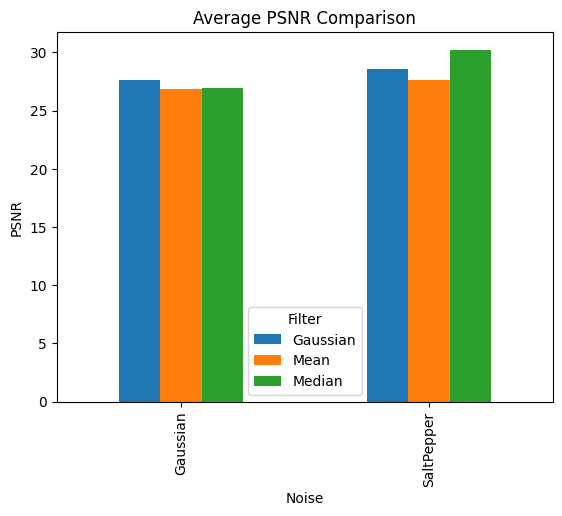

In [11]:
import matplotlib.pyplot as plt

summary = df.groupby(["Noise", "Filter"])["PSNR"].mean().unstack()

summary.plot(kind="bar")
plt.title("Average PSNR Comparison")
plt.ylabel("PSNR")
plt.show()